<a href="https://colab.research.google.com/github/avocadopelvis/customer-segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download imakash3011/customer-personality-analysis

  0% 0.00/62.0k [00:00<?, ?B/s]
100% 62.0k/62.0k [00:00<00:00, 9.33MB/s]


In [ ]:
!unzip customer-personality-analysis.zip

Archive:  customer-personality-analysis.zip
  inflating: marketing_campaign.csv  


In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import datetime
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

np.random.seed(42)

In [ ]:
#load the dataset
data = pd.read_csv('/content/marketing_campaign.csv', sep='\t')
print('Number of datapoints:', len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


### DATA CLEANING

In [ ]:
#information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

#### We can observe that:


*   There are missing values in income.
*   Dt_Customer (Date of Customer's enrollment with the company) is not parsed as DateTime.

For the missing income values, I am simply going to drop the rows containing them.



In [ ]:
#to remove the NA values
data = data.dropna()
print("Total number of data points after removing rows with missing income values:" , len(data))

Total number of data points after removing rows with missing income values: 2216


To handle **Dt_Customer**,  I am going to create a new feature (Customer_For) out of it which will indicate the number of days a customer is registered in the database. To keep it simple, I am taking this value relative to the most recent customer in the record.

Thus to get the values, I must check the newest & oldest recorded dates.

In [ ]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
dates = []
for i in data['Dt_Customer']:
  i = i.date()
  dates.append(i)

#dates of the newest & oldest recorded customer
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))

The newest customer's enrolment date in the records: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#create the feature "Customer_For"
days = []
d1 = max(dates) #newest customer

for i in dates:
  delta = d1 - i
  days.append(delta)

data['Customer_For'] = days
data['Customer_For'] = pd.to_numeric(data['Customer_For'], errors = 'coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Year_Birth           2216 non-null   int64         
 2   Education            2216 non-null   object        
 3   Marital_Status       2216 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2216 non-null   int64         
 6   Teenhome             2216 non-null   int64         
 7   Dt_Customer          2216 non-null   datetime64[ns]
 8   Recency              2216 non-null   int64         
 9   MntWines             2216 non-null   int64         
 10  MntFruits            2216 non-null   int64         
 11  MntMeatProducts      2216 non-null   int64         
 12  MntFishProducts      2216 non-null   int64         
 13  MntSweetProducts     2216 non-nul

### Now, let us explore the unique values in the categoriacal features.

In [ ]:
print("Total categories in the feature Marital: \n", data['Marital_Status'].value_counts(), '\n')
print("Total categories in the feature Education:\n", data['Education'].value_counts())

Total categories in the feature Marital: 
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


### Feature Engineering

In [ ]:
#current age of customer
data['Age'] = 2021 - data['Year_Birth']

#total spendings on various items
data['Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#deriving living situation with marital status
data['Living_With'] = data['Marital_Status'].replace({'Married': 'Partner', 'Together': 'Partner', 'Absurd': 'Alone', 'Widow': 'Alone', 'YOLO': 'Alone', 'Divorced': 'Alone', 'Single': 'Alone'})

#total children living in the household
data['Children'] = data['Kidhome'] + data['Teenhome']

#total members in the household
data['Family_Size'] = data['Living_With'].replace({'Alone': 1, 'Partner': 2}) + data['Children']

#if cutomer is a parent
data['Is_Parent'] = np.where(data.Children > 0, 1, 0) #if data.Children > 0 then 1 (Yes) or else 0 (No)

#segmenting education levels in three groups
data['Education'] = data['Education'].replace({'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'})

#renaming feature for clarity
data = data.rename(columns = {'MntWines': 'Wines', 'MntFruits': 'Fruits', 'MntMeatProducts': 'Meat', 'MntFishProducts': 'Fish', 'MntSweetProducts': 'Sweets', 'MntGoldProds': 'Gold'})

#dropping redundant features
to_drop = ['Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
data = data.drop(to_drop, axis = 1)

In [ ]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


#### The above stats show some discrepancies in mean Income & Age and max Income & Age

#### To take a look at the broader view of the data, I will plot some selected features

Relative plot of some selected features: A Data Subset


<Figure size 576x396 with 0 Axes>

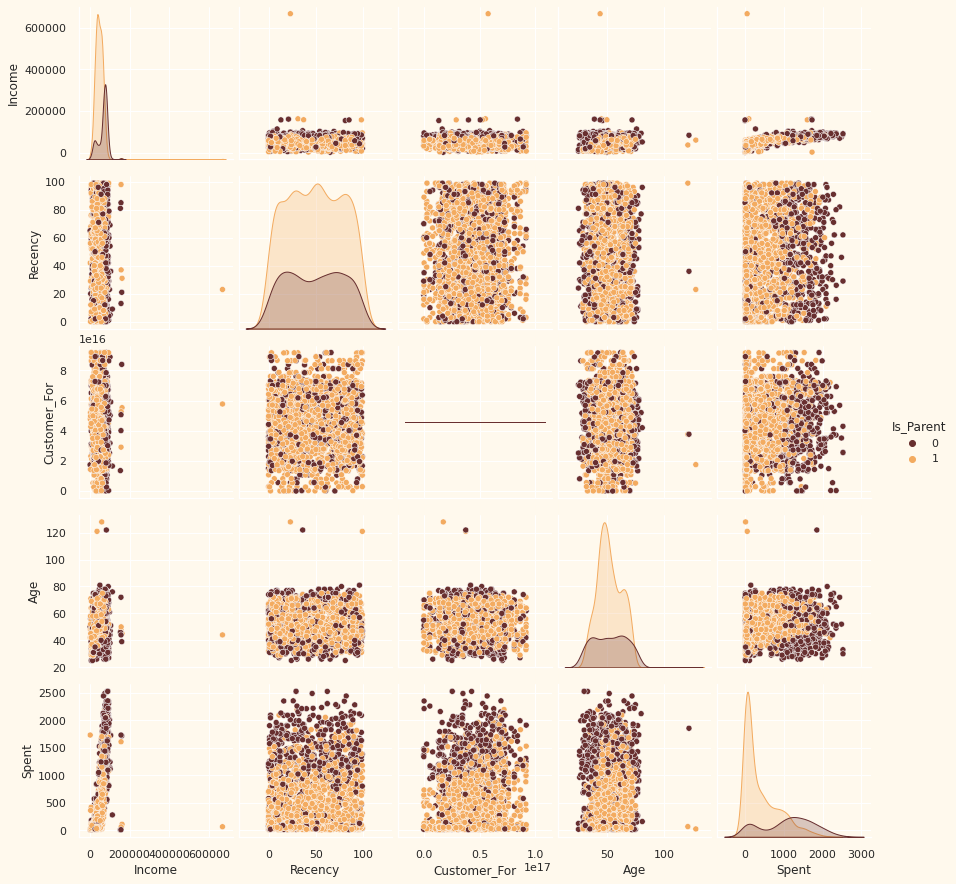

In [ ]:
sns.set(rc = {'axes.facecolor' : '#FFF9ED', 'figure.facecolor': '#FFF9ED'})
pallete = ['#682F2F', '#9E726F', '#D6B2B1', '#B9C0C9', '#9F8A78', '#F3AB60']
cmap = colors.ListedColormap(['#682F2F', '#9E726F', '#D6B2B1', '#B9C0C9', '#9F8A78', '#F3AB60'])

to_plot = ['Income', 'Recency', 'Customer_For', 'Age', 'Spent', 'Is_Parent']
print('Relative plot of some selected features: A Data Subset')
plt.figure()
sns.pairplot(data[to_plot], hue = 'Is_Parent', palette = (['#682F2F', '#F3AB60']))
plt.show()

#### From the above plots, it is clear that there are a few outliers in the Income & Age features. I will be deleting the outliers in the data by setting a cap on Income & Age

In [ ]:
#dropping the outliers
data = data[(data['Income'] < 600000)]
data = data[(data['Age'] < 90)]
print('Total number of data points after removing the outliers are: ', len(data))

Total number of data points after removing the outliers are:  2212


#### Let us look at the correlation amongst the features.

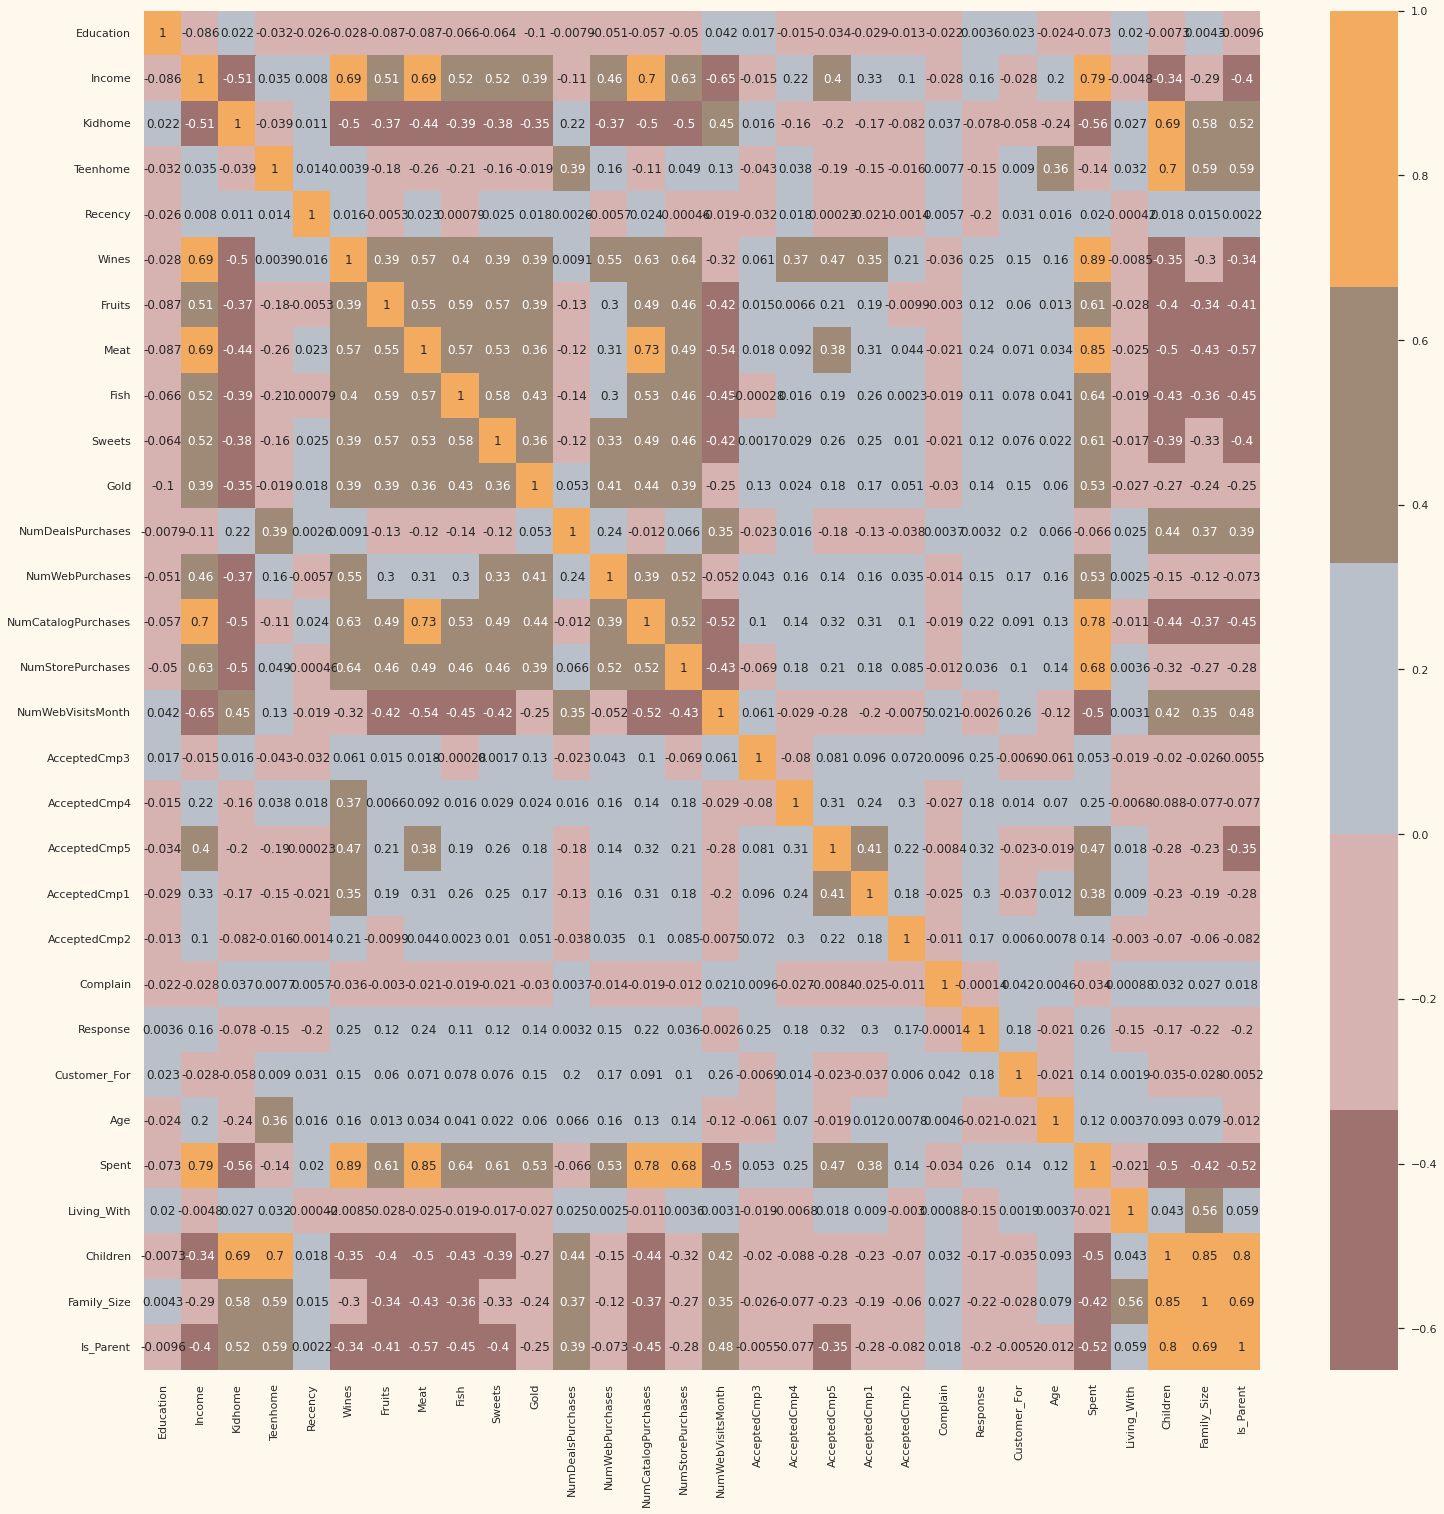

In [ ]:
#correlation matrix
corrmat = data.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(corrmat, annot = True, cmap = cmap, center = 0)

### DATA PREPROCESSING

#### First,  we will label encode the categorical features.






In [ ]:
#get list of categorical features
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print('Categorical features in the dataset:', object_cols)

Categorical features in the dataset: ['Education', 'Living_With']


In [ ]:
#label encoding the categorical features
le = LabelEncoder()
for i in object_cols:
  data[i] = data[[i]].apply(le.fit_transform)

#### Now, we will create a subset dataframe in which we drop the features on complain & offers accepted.

In [ ]:
#creating a copy of the data
ds = data.copy()

#creating a subset dataframe
cols_del = ['Complain', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
ds = ds.drop(cols_del, axis = 1)

#### We will now scale the features using the standard scaler.

In [ ]:
#scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns = ds.columns)
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


### DIMENSIONALITY REDUCTION

In [ ]:
#dimensionality reduction using PCA
pca = PCA(n_components = 3)
pca.fit(scaled_ds)
pca_ds = pd.DataFrame(pca.transform(scaled_ds), columns = (['col1', 'col2', 'col3']))
pca_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-2.212416e-16,2.878377,-5.969396,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,1.195548e-16,1.706839,-4.312257,-1.328250,-0.157911,1.242254,6.142652
col3,2212.0,4.582430e-17,1.221957,-3.530594,-0.829114,-0.021687,0.799738,6.617451


<function matplotlib.pyplot.show>

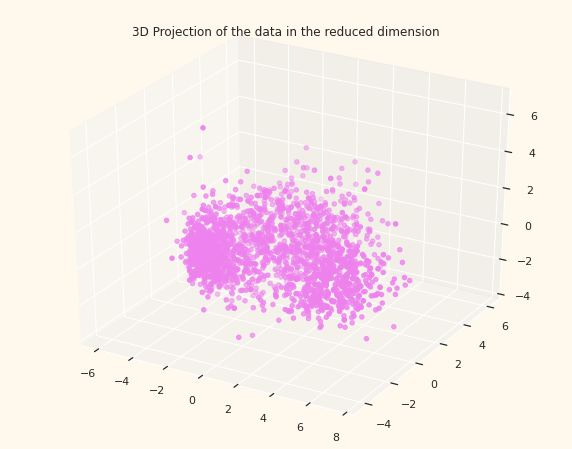

In [ ]:
#3D projection of the data in the reduced dimension
x = pca_ds['col1']
y = pca_ds['col2']
z = pca_ds['col3']

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x, y, z, c = 'violet', marker = 'o')
ax.set_title('3D Projection of the data in the reduced dimension')
plt.show

### CLUSTERING

#### To find the optimal number of clusters, we will use the elbow method.

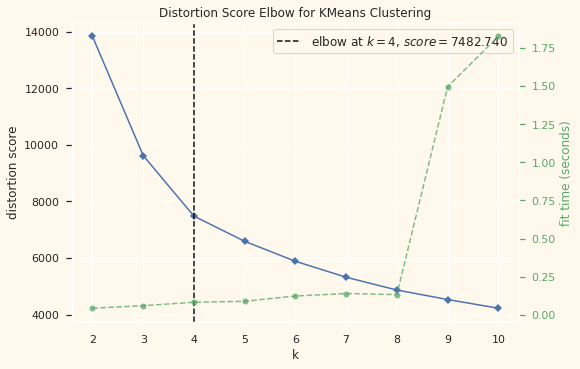

In [ ]:
#elbow method
elbow = KElbowVisualizer(KMeans(), k=10)
elbow.fit(pca_ds)
elbow.show()

#### From the above plot, we can observe that four will be the optimal number of clusters for this data.

#### Now, we will be performing clustering via Agglomerative clustering.

In [ ]:
#agglomerative clustering
ac = AgglomerativeClustering(n_clusters = 4)
yhat_ac = ac.fit_predict(pca_ds)
pca_ds['Clusters'] = yhat_ac

#adding clusters feature to the original dataframe
data['Clusters'] = yhat_ac

#### To examine the clusters formed, let's have a look at the 3D distribution of the clusters.

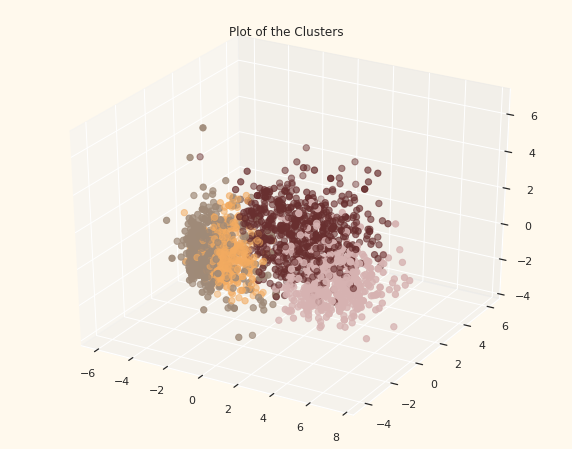

In [ ]:
#plotting the clusters
fig = plt.figure(figsize = (10, 8))
ax = plt.subplot(111, projection = '3d', label = 'bla')
ax.scatter(x, y, z, s = 40, c = pca_ds['Clusters'], marker = 'o', cmap = cmap) #s: marker size
ax.set_title('Plot of the Clusters')
plt.show()